### Setup

In [2]:
%matplotlib inline
import nltk
from textblob import TextBlob
import pandas as pd
import pymongo
import numpy as np
from datetime import datetime
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nltk.util import ngrams
from collections import defaultdict
from operator import itemgetter
from sklearn.externals import joblib

In [3]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', '"', ':', '/', ""]

In [4]:
def calc_day(dt):
    date = dt[:10] + " " + dt[-4:]
    return datetime.strptime(date, '%a %b %d %Y').strftime('%D')

In [5]:
def polarity_group_func(text):
    if TextBlob(text).polarity < 0:
        return 'Negative'
    if TextBlob(text).polarity > 0:
        return 'Positive'
    if TextBlob(text).polarity == 0:
        return 'Neutral'

In [6]:
def rounded_subj(text):
    return round(TextBlob(text).subjectivity,1)

# Celtics

### Sentiment Analysis, Fix Date, Add Team

In [7]:
client = pymongo.MongoClient()
db = client.nbabeatwritertweets
celtics = client.nbabeatwritertweets.celtics

In [8]:
for doc in celtics.find({}, {"text": 1, "datetime": 1}):
    polarity = TextBlob(doc["text"]).polarity
    subjectivity = TextBlob(doc["text"]).subjectivity
    polarity_group = polarity_group_func(doc["text"])
    subjectivity_group = rounded_subj(doc["text"])
    date = calc_day(doc['datetime'])
    team = 'Boston Celtics'.encode('utf-8')
    celtics.update_one({"_id": doc["_id"]}, {"$set": {"polarity": polarity, 
                                                      "subjectivity": subjectivity,
                                                      "polarity_group": polarity_group,
                                                      "subjectivity_group": subjectivity_group,
                                                      "date": date,
                                                      "team": team}})

In [9]:
for doc in celtics.find({}, {"reporter": 1, 
                             "text": 1, 
                             "polarity": 1, 
                             "subjectivity": 1,
                             "polarity_group": 1,
                             "subjectivity_group": 1,
                             "date": 1,
                             "team": 1,
                             "_id": 0}).limit(5):
    print doc

{u'polarity': 0.06666666666666667, u'reporter': u'Steve Bulpett', u'text': u'Back in the parallel video board universe, Gino warming up his hamstrings, getting ready to dance. Someone tell KG to turn on league pass.', u'polarity_group': u'Positive', u'team': u'Boston Celtics', u'subjectivity_group': 0.2, u'subjectivity': 0.16666666666666666, u'date': u'11/07/15'}
{u'polarity': 0.0, u'reporter': u'Steve Bulpett', u'text': u"Today's column quotes Auerbach and Wooden. In heaven. (Wait until the Herald sees the expense report for this trip.) https://t.co/QYDgYPhuxR", u'polarity_group': u'Neutral', u'team': u'Boston Celtics', u'subjectivity_group': 0.0, u'subjectivity': 0.0, u'date': u'11/07/15'}
{u'polarity': -0.16666666666666666, u'reporter': u'Steve Bulpett', u'text': u"Tyler Zeller has gone from Celts' starting center to waiting for Gino to hit the video board so he can get into the game. DNP through 3Q.", u'polarity_group': u'Negative', u'team': u'Boston Celtics', u'subjectivity_group'

### Topic Modeling

In [10]:
tweets = []
for doc in celtics.find({}, {"text": 1}):
    tweet = doc["text"]
    tweets.append(tweet)

In [11]:
text = [" ".join([w for w in doc.lower().split() if w not in stop]) for doc in tweets]

In [12]:
vectorizer = CountVectorizer()
vectorizer.fit(text)
x = vectorizer.transform(text)
x_back = x.toarray()
X_bag = pd.DataFrame(x_back, columns=vectorizer.get_feature_names())

In [13]:
scaler = MinMaxScaler()
X_bag_scaled = pd.DataFrame(scaler.fit_transform(X_bag), columns=X_bag.columns)

In [14]:
reducer = PCA(n_components = 2)
reduced_X = reducer.fit_transform(X_bag_scaled)

In [15]:
pca_components = reducer.components_

In [16]:
print pca_components
print pca_components.shape

[[ 0.00027331  0.00028329  0.00022203 ...,  0.00025207  0.00061244
   0.0003165 ]
 [-0.00114404  0.00070277 -0.00057333 ...,  0.00260754  0.00030244
   0.00206887]]
(2, 4419)


In [23]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(reduced_X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [24]:
joblib.dump(kmeans, 'celtics_kmeans.pkl')

['celtics_kmeans.pkl',
 'celtics_kmeans.pkl_01.npy',
 'celtics_kmeans.pkl_02.npy']

In [25]:
kmeans = joblib.load('celtics_kmeans.pkl')

In [26]:
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
n_clusters = len(k_means_cluster_centers)

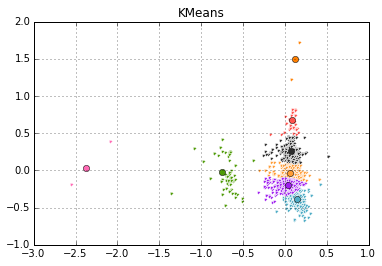

In [27]:
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#FF69B4', '#A020F0', '#FF524D', '#FF7F00', '#2D2D2D', '#585555', '#601c1c']
plt.figure()
plt.hold(True)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(reduced_X[my_members, 0], reduced_X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
plt.title('KMeans')    
plt.grid(True)
plt.show()

0 - Blue, 1 - Yellow, 2 - Green, 3 - Pink, 4 - Purple, 5 - Red, 6 - Orange, 7 - Black

In [38]:
topics = {0: 'Marcus Smart',
          1: 'Rookies',
          2: 'Evan Turner',
          3: 'Evan Turner',
          4: 'Brad Stevens',
          5: 'Danny Ainge',
          6: 'Gameplay',
          7: 'RJ Hunter'}

In [28]:
grouped_tweets = zip(text,k_means_labels)

In [29]:
group_0 = [tup for tup in grouped_tweets if tup[1] == 0]
group_1 = [tup for tup in grouped_tweets if tup[1] == 1]
group_2 = [tup for tup in grouped_tweets if tup[1] == 2]
group_3 = [tup for tup in grouped_tweets if tup[1] == 3]
group_4 = [tup for tup in grouped_tweets if tup[1] == 4]
group_5 = [tup for tup in grouped_tweets if tup[1] == 5]
group_6 = [tup for tup in grouped_tweets if tup[1] == 6]
group_7 = [tup for tup in grouped_tweets if tup[1] == 7]

In [30]:
counter_0 = defaultdict(int)

n = 2
for tweet,group in group_0:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_0[gram] += 1
        
for gram, count in sorted(counter_0.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

        marcus smart 106
        brad stevens 59
         jae crowder 50
     jared sullinger 48
       avery bradley 32


In [31]:
counter_1 = defaultdict(int)

n = 2
for tweet,group in group_1:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_1[gram] += 1
        
for gram, count in sorted(counter_1.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

           rj hunter 38
        brad stevens 36
         james young 26
        celtics fans 24
        marcus smart 24


In [32]:
counter_2 = defaultdict(int)

n = 2
for tweet,group in group_2:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_2[gram] += 1
        
for gram, count in sorted(counter_2.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

         evan turner 113
        brad stevens 26
      breath alcohol 18
          half court 13
        office drugs 13


In [33]:
counter_3 = defaultdict(int)

n = 2
for tweet,group in group_3:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_3[gram] += 1
        
for gram, count in sorted(counter_3.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

           make logo 37
         evan turner 37
           would get 23
             'd make 23
         women would 23


In [34]:
counter_4 = defaultdict(int)

n = 2
for tweet,group in group_4:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_4[gram] += 1
        
for gram, count in sorted(counter_4.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

        brad stevens 109
       isaiah thomas 66
        marcus smart 41
       avery bradley 41
       celtics coach 31


In [35]:
counter_5 = defaultdict(int)

n = 2
for tweet,group in group_5:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_5[gram] += 1
        
for gram, count in sorted(counter_5.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

           's sunday 13
        bird message 13
         danny ainge 13
           herald 's 13
https t.co/gr8vk3njjd 13


In [36]:
counter_6 = defaultdict(int)

n = 2
for tweet,group in group_6:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_6[gram] += 1
        
for gram, count in sorted(counter_6.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

       kevin garnett 35
      reacting hawks 19
           win https 19
   casually reacting 19
       miss clinched 19


In [37]:
counter_7 = defaultdict(int)

n = 2
for tweet,group in group_7:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_7[gram] += 1
        
for gram, count in sorted(counter_7.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

        brad stevens 37
           rj hunter 34
         james young 28
                c 's 25
           n't count 24


In [38]:
topics = {0: 'Marcus Smart',
          1: 'Rookies',
          2: 'Evan Turner',
          3: 'Evan Turner',
          4: 'Brad Stevens',
          5: 'Danny Ainge',
          6: 'Gameplay',
          7: 'RJ Hunter'}

### Add Topic to Data

In [39]:
_ids = []
for doc in celtics.find({}, {}):
    _id = doc["_id"]
    _ids.append(_id)

In [40]:
id_groups = zip(_ids,k_means_labels)

In [41]:
id_group_dict = {str(_id): group for _id, group in id_groups}

In [42]:
for doc in celtics.find({}, {}):
    topic = topics[id_group_dict[str(doc["_id"])]]
    celtics.update_one({"_id": doc["_id"]}, {"$set": {"topic": topic}})

In [43]:
for doc in celtics.find({}, {"text": 1, 
                             "topic": 1,
                             "_id": 0}).limit(5):
    print doc

{u'topic': u'Rookies', u'text': u'Back in the parallel video board universe, Gino warming up his hamstrings, getting ready to dance. Someone tell KG to turn on league pass.'}
{u'topic': u'RJ Hunter', u'text': u"Today's column quotes Auerbach and Wooden. In heaven. (Wait until the Herald sees the expense report for this trip.) https://t.co/QYDgYPhuxR"}
{u'topic': u'Brad Stevens', u'text': u"Tyler Zeller has gone from Celts' starting center to waiting for Gino to hit the video board so he can get into the game. DNP through 3Q."}
{u'topic': u'Brad Stevens', u'text': u"Sullinger asks out of game. While he's waiting for help, he hits his 2nd straight 3, rebounds Beal miss and outlets to Thomas for FB layup."}
{u'topic': u'Brad Stevens', u'text': u'Celts lead Washington 72-49 at half. Refs sweating hard as they head to dressing room. Somebody get my man Joey Crawford some oxygen.'}


# Knicks

### Sentiment Analysis, Fix Date, Add Team

In [44]:
client = pymongo.MongoClient()
db = client.nbabeatwritertweets
knicks = client.nbabeatwritertweets.knicks

In [45]:
for doc in knicks.find({}, {"text": 1, "datetime": 1}):
    polarity = TextBlob(doc["text"]).polarity
    subjectivity = TextBlob(doc["text"]).subjectivity
    polarity_group = polarity_group_func(doc["text"])
    subjectivity_group = rounded_subj(doc["text"])
    date = calc_day(doc['datetime'])
    team = 'New York Knicks'.encode('utf-8')
    knicks.update_one({"_id": doc["_id"]}, {"$set": {"polarity": polarity, 
                                                      "subjectivity": subjectivity,
                                                      "polarity_group": polarity_group,
                                                      "subjectivity_group": subjectivity_group,
                                                      "date": date,
                                                      "team": team}})

In [46]:
for doc in knicks.find({}, {"reporter": 1, 
                             "text": 1, 
                             "polarity": 1, 
                             "subjectivity": 1,
                             "polarity_group": 1,
                             "subjectivity_group": 1,
                             "date": 1,
                             "team": 1,
                             "_id": 0}).limit(5):
    print doc

{u'polarity': 0.0, u'reporter': u'Al Iannazzone', u'text': u"Carmelo Anthony likes the shots he's getting but he's bothered by all the misses: https://t.co/Qqsw696DS0", u'polarity_group': u'Neutral', u'team': u'New York Knicks', u'subjectivity_group': 0.0, u'subjectivity': 0.0, u'date': u'11/05/15'}
{u'polarity': 0.25, u'reporter': u'Al Iannazzone', u'text': u"First LeBron ripped his sleeves, then he ripped the Knicks' hearts out: https://t.co/3zhMC7yePM", u'polarity_group': u'Positive', u'team': u'New York Knicks', u'subjectivity_group': 0.3, u'subjectivity': 0.3333333333333333, u'date': u'11/05/15'}
{u'polarity': 0.0, u'reporter': u'Al Iannazzone', u'text': u"I'd like @ScottCacciola and @StevePopper to be forever retired from sporting events. https://t.co/PHPZLwVJQH", u'polarity_group': u'Neutral', u'team': u'New York Knicks', u'subjectivity_group': 0.0, u'subjectivity': 0.0, u'date': u'11/05/15'}
{u'polarity': -0.09999999999999998, u'reporter': u'Al Iannazzone', u'text': u"Bad foul 

### Topic Modeling

In [47]:
tweets = []
for doc in knicks.find({}, {"text": 1}):
    tweet = doc["text"]
    tweets.append(tweet)

In [48]:
text = [" ".join([w for w in doc.lower().split() if w not in stop]) for doc in tweets]

In [49]:
vectorizer = CountVectorizer()
vectorizer.fit(text)
x = vectorizer.transform(text)
x_back = x.toarray()
X_bag = pd.DataFrame(x_back, columns=vectorizer.get_feature_names())

In [50]:
scaler = MinMaxScaler()
X_bag_scaled = pd.DataFrame(scaler.fit_transform(X_bag), columns=X_bag.columns)

In [51]:
reducer = PCA(n_components = 2)
reduced_X = reducer.fit_transform(X_bag_scaled)

In [52]:
pca_components = reducer.components_

In [53]:
print pca_components
print pca_components.shape

[[  7.02910593e-05   5.87328929e-04   7.03559931e-05 ...,   7.04031087e-05
    2.35929683e-04   3.11270163e-04]
 [  2.01254573e-04   3.88497000e-04   3.94813521e-04 ...,  -1.49915715e-04
   -1.73915857e-04  -2.57416439e-04]]
(2, 3364)


In [69]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(reduced_X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [70]:
joblib.dump(kmeans, 'knicks_kmeans.pkl')

['knicks_kmeans.pkl', 'knicks_kmeans.pkl_01.npy', 'knicks_kmeans.pkl_02.npy']

In [71]:
kmeans = joblib.load('knicks_kmeans.pkl')

In [72]:
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
n_clusters = len(k_means_cluster_centers)

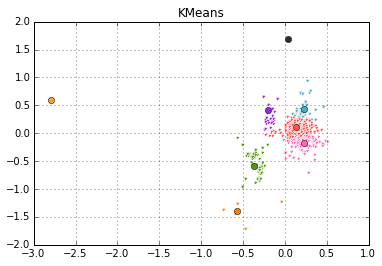

In [73]:
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#FF69B4', '#A020F0', '#FF524D', '#FF7F00', '#2D2D2D', '#585555', '#601c1c']
plt.figure()
plt.hold(True)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(reduced_X[my_members, 0], reduced_X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
plt.title('KMeans')    
plt.grid(True)
plt.show()

0 - Blue, 1 - Yellow, 2 - Green, 3 - Pink, 4 - Purple, 5 - Red, 6 - Orange, 7 - Black

In [84]:
topics = {0: 'Madison Square Garden',
          1: 'Kristaps Porzingis',
          2: 'Kristaps Porzingis',
          3: 'Carmelo Anthony',
          4: 'Langston Galloway',
          5: 'Derek Fisher',
          6: 'Kristaps Porzingis',
          7: 'Derek Fisher'}

In [74]:
grouped_tweets = zip(text,k_means_labels)

In [75]:
group_0 = [tup for tup in grouped_tweets if tup[1] == 0]
group_1 = [tup for tup in grouped_tweets if tup[1] == 1]
group_2 = [tup for tup in grouped_tweets if tup[1] == 2]
group_3 = [tup for tup in grouped_tweets if tup[1] == 3]
group_4 = [tup for tup in grouped_tweets if tup[1] == 4]
group_5 = [tup for tup in grouped_tweets if tup[1] == 5]
group_6 = [tup for tup in grouped_tweets if tup[1] == 6]
group_7 = [tup for tup in grouped_tweets if tup[1] == 7]

In [76]:
counter_0 = defaultdict(int)

n = 2
for tweet,group in group_0:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_0[gram] += 1
        
for gram, count in sorted(counter_0.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

         kobe bryant 52
        derek fisher 41
       square garden 23
      madison square 23
         yet happens 22


In [77]:
counter_1 = defaultdict(int)

n = 2
for tweet,group in group_1:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_1[gram] += 1
        
for gram, count in sorted(counter_1.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

            home run 69
         smart funny 69
    porzingis humble 69
        humble smart 69
     talented knicks 69


In [78]:
counter_2 = defaultdict(int)

n = 2
for tweet,group in group_2:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_2[gram] += 1
        
for gram, count in sorted(counter_2.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

  kristaps porzingis 168
       look kristaps 28
           points 10 22
         10 rebounds 22
             's look 18


In [79]:
counter_3 = defaultdict(int)

n = 2
for tweet,group in group_3:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_3[gram] += 1
        
for gram, count in sorted(counter_3.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

     carmelo anthony 34
             first 7 29
https t.co/6drgg8mbke 25
          via nypost 24
           17 points 22


In [80]:
counter_4 = defaultdict(int)

n = 2
for tweet,group in group_4:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_4[gram] += 1
        
for gram, count in sorted(counter_4.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

   langston galloway 25
              's hit 17
          put knicks 16
            best nba 16
   3-pointers season 16


In [81]:
counter_5 = defaultdict(int)

n = 2
for tweet,group in group_5:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_5[gram] += 1
        
for gram, count in sorted(counter_5.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

        derek fisher 46
     jimmer fredette 40
   langston galloway 36
       arron afflalo 29
       galloway went 28


In [82]:
counter_6 = defaultdict(int)

n = 2
for tweet,group in group_6:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_6[gram] += 1
        
for gram, count in sorted(counter_6.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

  kristaps porzingis 80
            'm still 50
            guy he’s 37
           white guy 37
          he’s going 37


In [83]:
counter_7 = defaultdict(int)

n = 2
for tweet,group in group_7:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_7[gram] += 1
        
for gram, count in sorted(counter_7.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

    fisher remembers 18
        derek fisher 18
             kobe 's 18
        game madison 18
          lot pretty 18


In [84]:
topics = {0: 'Madison Square Garden',
          1: 'Kristaps Porzingis',
          2: 'Kristaps Porzingis',
          3: 'Carmelo Anthony',
          4: 'Langston Galloway',
          5: 'Derek Fisher',
          6: 'Kristaps Porzingis',
          7: 'Derek Fisher'}

### Add Topic to Data

In [85]:
_ids = []
for doc in knicks.find({}, {}):
    _id = doc["_id"]
    _ids.append(_id)

In [86]:
id_groups = zip(_ids,k_means_labels)

In [87]:
id_group_dict = {str(_id): group for _id, group in id_groups}

In [88]:
for doc in knicks.find({}, {}):
    topic = topics[id_group_dict[str(doc["_id"])]]
    knicks.update_one({"_id": doc["_id"]}, {"$set": {"topic": topic}})

In [89]:
for doc in knicks.find({}, {"text": 1, 
                             "topic": 1,
                             "_id": 0}).limit(5):
    print doc

{u'topic': u'Carmelo Anthony', u'text': u"Carmelo Anthony likes the shots he's getting but he's bothered by all the misses: https://t.co/Qqsw696DS0"}
{u'topic': u'Carmelo Anthony', u'text': u"First LeBron ripped his sleeves, then he ripped the Knicks' hearts out: https://t.co/3zhMC7yePM"}
{u'topic': u'Carmelo Anthony', u'text': u"I'd like @ScottCacciola and @StevePopper to be forever retired from sporting events. https://t.co/PHPZLwVJQH"}
{u'topic': u'Carmelo Anthony', u'text': u"Bad foul by Porzingis. He was out of position and pushed Mozgov for his fourth foul, and he's having another good game with 13 points."}
{u'topic': u'Derek Fisher', u'text': u"Knicks went 5 1/2 minutes without a field goal but still lead Cavs 42-37 after a Porzingis' put-back dunk."}


# Lakers

### Sentiment Analysis, Fix Date, Add Team

In [90]:
client = pymongo.MongoClient()
db = client.nbabeatwritertweets
lakers = client.nbabeatwritertweets.lakers

In [91]:
for doc in lakers.find({}, {"text": 1, "datetime": 1}):
    polarity = TextBlob(doc["text"]).polarity
    subjectivity = TextBlob(doc["text"]).subjectivity
    polarity_group = polarity_group_func(doc["text"])
    subjectivity_group = rounded_subj(doc["text"])
    date = calc_day(doc['datetime'])
    team = 'Los Angelas Lakers'.encode('utf-8')
    lakers.update_one({"_id": doc["_id"]}, {"$set": {"polarity": polarity, 
                                                      "subjectivity": subjectivity,
                                                      "polarity_group": polarity_group,
                                                      "subjectivity_group": subjectivity_group,
                                                      "date": date,
                                                      "team": team}})

In [92]:
for doc in lakers.find({}, {"reporter": 1, 
                             "text": 1, 
                             "polarity": 1, 
                             "subjectivity": 1,
                             "polarity_group": 1,
                             "subjectivity_group": 1,
                             "date": 1,
                             "team": 1,
                             "_id": 0}).limit(5):
    print doc

{u'polarity': 0.0, u'reporter': u'Mike Bresnahan', u'text': u"Here's one thing Kobe won't do when he's done playing: Coaching. \u201cI don\u2019t feel like dealing with divas. They\u2019re a pain in the ass,\u201d he said.", u'polarity_group': u'Neutral', u'team': u'Los Angelas Lakers', u'subjectivity_group': 0.0, u'subjectivity': 0.0, u'date': u'11/07/15'}
{u'polarity': 0.0, u'reporter': u'Mike Bresnahan', u'text': u'Jordan Clarkson taking pictures of the cameras following Kobe around for his documentary. https://t.co/3ea9lA2kce', u'polarity_group': u'Neutral', u'team': u'Los Angelas Lakers', u'subjectivity_group': 0.1, u'subjectivity': 0.05, u'date': u'11/07/15'}
{u'polarity': 0.0, u'reporter': u'Mike Bresnahan', u'text': u"Only two outcomes left for Kobe...Retire or return to Lakers: 'Laker for life' Bryant says he won't sign elsewhere https://t.co/8wdeS8coPX", u'polarity_group': u'Neutral', u'team': u'Los Angelas Lakers', u'subjectivity_group': 0.5, u'subjectivity': 0.5, u'date': u

### Topic Modeling

In [93]:
tweets = []
for doc in lakers.find({}, {"text": 1}):
    tweet = doc["text"]
    tweets.append(tweet)

In [94]:
text = [" ".join([w for w in doc.lower().split() if w not in stop]) for doc in tweets]

In [95]:
vectorizer = CountVectorizer()
vectorizer.fit(text)
x = vectorizer.transform(text)
x_back = x.toarray()
X_bag = pd.DataFrame(x_back, columns=vectorizer.get_feature_names())

In [96]:
scaler = MinMaxScaler()
X_bag_scaled = pd.DataFrame(scaler.fit_transform(X_bag), columns=X_bag.columns)

In [97]:
reducer = PCA(n_components = 2)
reduced_X = reducer.fit_transform(X_bag_scaled)

In [98]:
pca_components = reducer.components_

In [99]:
print pca_components
print pca_components.shape

[[  2.36106924e-03  -7.22033275e-04   6.01957714e-04 ...,  -2.25834590e-03
   -1.52478920e-03  -8.87324320e-04]
 [  3.75001040e-03   7.65858815e-05   5.38134447e-04 ...,  -1.33522407e-04
    2.91770444e-04   3.63106293e-04]]
(2, 4566)


In [100]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(reduced_X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [101]:
joblib.dump(kmeans, 'lakers_kmeans.pkl')

['lakers_kmeans.pkl', 'lakers_kmeans.pkl_01.npy', 'lakers_kmeans.pkl_02.npy']

In [102]:
kmeans = joblib.load('lakers_kmeans.pkl')

In [103]:
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
n_clusters = len(k_means_cluster_centers)

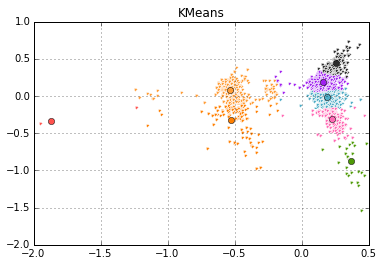

In [104]:
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#FF69B4', '#A020F0', '#FF524D', '#FF7F00', '#2D2D2D', '#585555', '#601c1c']
plt.figure()
plt.hold(True)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(reduced_X[my_members, 0], reduced_X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
plt.title('KMeans')    
plt.grid(True)
plt.show()

0 - Blue, 1 - Yellow, 2 - Green, 3 - Pink, 4 - Purple, 5 - Red, 6 - Orange, 7 - Black

In [105]:
grouped_tweets = zip(text,k_means_labels)

In [106]:
group_0 = [tup for tup in grouped_tweets if tup[1] == 0]
group_1 = [tup for tup in grouped_tweets if tup[1] == 1]
group_2 = [tup for tup in grouped_tweets if tup[1] == 2]
group_3 = [tup for tup in grouped_tweets if tup[1] == 3]
group_4 = [tup for tup in grouped_tweets if tup[1] == 4]
group_5 = [tup for tup in grouped_tweets if tup[1] == 5]
group_6 = [tup for tup in grouped_tweets if tup[1] == 6]
group_7 = [tup for tup in grouped_tweets if tup[1] == 7]

In [107]:
counter_0 = defaultdict(int)

n = 2
for tweet,group in group_0:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_0[gram] += 1
        
for gram, count in sorted(counter_0.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

         byron scott 75
    d’angelo russell 61
             kobe 's 60
        derek fisher 55
         kobe bryant 45


In [108]:
counter_1 = defaultdict(int)

n = 2
for tweet,group in group_1:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_1[gram] += 1
        
for gram, count in sorted(counter_1.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

    d'angelo russell 55
     jordan clarkson 30
           6-6 lower 26
        merion https 26
         world peace 26


In [109]:
counter_2 = defaultdict(int)

n = 2
for tweet,group in group_2:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_2[gram] += 1
        
for gram, count in sorted(counter_2.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

          scott said 101
           last year 97
           said kobe 71
          might last 62
         byron scott 62


In [110]:
counter_3 = defaultdict(int)

n = 2
for tweet,group in group_3:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_3[gram] += 1
        
for gram, count in sorted(counter_3.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

         kobe bryant 153
         byron scott 97
             kobe 's 73
          scott said 54
          byron said 51


In [111]:
counter_4 = defaultdict(int)

n = 2
for tweet,group in group_4:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_4[gram] += 1
        
for gram, count in sorted(counter_4.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

    d'angelo russell 77
       julius randle 62
         world peace 61
         metta world 57
        lou williams 49


In [112]:
counter_5 = defaultdict(int)

n = 2
for tweet,group in group_5:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_5[gram] += 1
        
for gram, count in sorted(counter_5.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

https t.co/2nhidk8wdm 23
       kobe possibly 23
      possibly final 23
t.co/espwbgsqpd https 23
           final msg 23


In [113]:
counter_6 = defaultdict(int)

n = 2
for tweet,group in group_6:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_6[gram] += 1
        
for gram, count in sorted(counter_6.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

         kobe bryant 167
         byron scott 85
           last year 30
          last night 28
         asked today 25


In [114]:
counter_7 = defaultdict(int)

n = 2
for tweet,group in group_7:
    words = TextBlob(tweet).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    for gram in bigrams:
        counter_7[gram] += 1
        
for gram, count in sorted(counter_7.items(), key = itemgetter(1), reverse=True)[:5]:
    phrase = " ".join(gram)
    print '%20s %i' % (phrase, count)

            nance jr 90
         larry nance 79
          nick young 67
    d’angelo russell 64
           13 points 40


In [115]:
topics = {0: 'Kobe Bryant',
          1: "D'Angelo Russell",
          2: 'Byron Scott',
          3: 'Kobe Bryant',
          4: "Non-Kobe Lakers",
          5: 'Kobe Bryant',
          6: 'Kobe Bryant',
          7: 'Larry Nancy Jr.'}

### Add Topic to Data

In [116]:
_ids = []
for doc in lakers.find({}, {}):
    _id = doc["_id"]
    _ids.append(_id)

In [117]:
id_groups = zip(_ids,k_means_labels)

In [118]:
id_group_dict = {str(_id): group for _id, group in id_groups}

In [119]:
for doc in lakers.find({}, {}):
    topic = topics[id_group_dict[str(doc["_id"])]]
    lakers.update_one({"_id": doc["_id"]}, {"$set": {"topic": topic}})

In [120]:
for doc in lakers.find({}, {"text": 1, 
                             "topic": 1,
                             "_id": 0}).limit(5):
    print doc

{u'topic': u'Kobe Bryant', u'text': u"Here's one thing Kobe won't do when he's done playing: Coaching. \u201cI don\u2019t feel like dealing with divas. They\u2019re a pain in the ass,\u201d he said."}
{u'topic': u"D'Angelo Russell", u'text': u'Jordan Clarkson taking pictures of the cameras following Kobe around for his documentary. https://t.co/3ea9lA2kce'}
{u'topic': u'Kobe Bryant', u'text': u"Only two outcomes left for Kobe...Retire or return to Lakers: 'Laker for life' Bryant says he won't sign elsewhere https://t.co/8wdeS8coPX"}
{u'topic': u'Larry Nancy Jr.', u'text': u"D'Angelo Russell, Lakers on a roll. Rookie had 10 points in first half, Lakers lead Nets, 52-47."}
{u'topic': u'Non-Kobe Lakers', u'text': u"Laker GM Mitch Kupchak is in NY for tonight's game. He occasionally goes on road trips but I can't remember him ever traveling this early."}
